  # Test of XGBoost with One vs Rest model
  
 
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint as sp_randint
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.multiclass import OneVsRestClassifier

  ### Definition of names for plots and files

In [2]:

date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v5.1/dfcrossmatches_prioritized_v5.1.csv'

features_file = '../ZTF_data/features_20200109_with_WISE.csv'

class_output = '../ZTF_classifications/xgboost_classification_unlabelled_set_'+date+'.csv'

#where the RF models are saved
model_name = 'stat_xgboost_onevsrest/xgboost_onevsrest_'+date

#confusion matrixes
conf_matrix_name = 'stat_xgboost_onevsrest/confusion_matrix_xgboost_onevsrest_'+date


### reading the training set files 

In [3]:
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'r-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'r-W2']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 

df_feat['g-W3']=df_feat['Mean_1']-df_feat['W3']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W3']==-999) , 'g-W3']=-999
df_feat.loc[(df_feat['g-W3']>500) | (df_feat['g-W3']<-500) ,'g-W3']=-999 

df_feat['g-W2']=df_feat['Mean_1']-df_feat['W2']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W2']==-999), 'g-W2']=-999
df_feat.loc[(df_feat['g-W2']>500) | (df_feat['g-W3']<-500),'g-W2']=-999
#'''



#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)

170976


In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
#df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'EB'
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'EB'


#defining the classes included in the RF model
label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','Periodic-Other']

#label_order = ['QSO-I','AGN-I', 'Blazar','CV/Nova', 'YSO']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

labels.head()

,class_original
oid,
ZTF19aavdfaf,CV/Nova
ZTF19aaniokz,CV/Nova
ZTF18accatjz,CV/Nova
ZTF19aarfrrf,CV/Nova
ZTF19aarfrre,CV/Nova


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'aps_non_zero_1',
'aps_non_zero_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',  
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',  
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original']]
df.drop(['Mean_1','Mean_2','class_original'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

115941
115941
115941
115941


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abcoxgp,1.777660,1.612033,1.0,1.0,6.0,8.0,0.607143,0.626866,0.018519,0.000000,...,0.125000,0.194030,0.886667,0.983125,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000
ZTF18aaavxnm,1.545494,1.355183,1.0,1.0,1.0,1.0,0.100000,0.163636,0.000000,0.018868,...,0.700000,0.763636,0.808571,1.000000,0.439,1.925,4.700925,2.775925,4.654902,2.729902
ZTF18abmefme,1.741148,1.508885,1.0,1.0,1.0,1.0,0.529412,0.521739,0.000000,0.000000,...,0.431373,0.413043,0.912857,0.996042,0.168,2.829,4.799764,1.970764,4.865939,2.036939
ZTF17aabumpu,1.689769,1.102787,1.0,1.0,1.0,1.0,0.176471,0.315789,0.000000,0.000000,...,0.735294,0.631579,0.846667,0.790198,0.026,0.576,2.432245,1.856245,2.667624,2.091624
ZTF18aazmwvg,2.734478,2.477687,1.0,1.0,2.0,3.0,0.428571,0.442623,0.021277,0.000000,...,0.571429,0.655738,0.807857,0.980625,0.440,3.472,4.365933,0.893933,4.910711,1.438711


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_original = labels['class_original']#.values

le = LabelEncoder()

Y_original_encoded = le.fit_transform(Y_original)

X_original = df#.columns.values.tolist()



#splitting training set
X_train_original, X_test_original, y_train_original, y_test_original = model_selection.train_test_split(X_original,
Y_original_encoded, test_size=0.2, stratify=Y_original_encoded)

print(len(y_train_original))


92752


  ## Balanced XGBoost
  
 

In [8]:
#Training first layer of the RF model

class exgb_wrapper(imb_xgb):
    def __init__(self):
        super().__init__(num_round=100, max_depth=6, special_objective='weighted', imbalance_alpha=1.5)
    
    def predict_proba(self,X):
        return self.predict_two_class(X)
exgb_classifier = exgb_wrapper()


clf = OneVsRestClassifier(exgb_classifier).fit(X_train_original.values, y_train_original)


pred = clf.predict(X_test_original.values)
pred_proba = clf.predict_proba(X_test_original.values)

print(pred_proba)



[[1.9332222e-07 1.9489787e-06 3.0367979e-04 ... 7.3990572e-07
  2.1186124e-06 8.2574988e-05]
 [4.1638458e-07 2.2649440e-06 5.2539189e-04 ... 2.6033615e-06
  4.5968109e-06 1.0477564e-05]
 [7.0236558e-07 9.7010570e-07 3.5989297e-06 ... 1.8504370e-06
  1.9050459e-06 2.8695242e-06]
 ...
 [1.0911565e-03 9.8970366e-01 1.2364466e-05 ... 2.0415762e-06
  4.6986697e-06 4.7016281e-05]
 [8.7549939e-05 1.2402054e-05 1.3124301e-04 ... 6.6842526e-06
  4.3310583e-06 1.1940030e-04]
 [5.1147993e-07 1.1332043e-06 2.6246234e-06 ... 9.4340197e-07
  8.6391555e-07 6.8424967e-08]]


In [9]:
print(np.amax(pred_proba[500]))
print(pred_proba[500])
print(y_train_original[500])

0.9939345
[3.7241300e-06 4.5978668e-06 2.0909506e-06 5.9179420e-06 5.2006312e-06
 9.9393451e-01 9.3402411e-07 3.0801515e-05 2.4996244e-04 5.7392288e-03
 8.1236994e-06 2.9258024e-06 8.7287117e-06 1.1060183e-06 2.0775813e-06]
11


In [10]:
classes_order_proba = clf.classes_
print(classes_order_proba)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_test_original, pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, pred))

print("weighted precision: ","%0.2f" %  metrics.precision_score(y_test_original, pred, average='weighted'))
print("weighted recall: ","%0.2f" %  metrics.recall_score(y_test_original, pred, average='weighted'))
print("weighted F1: ","%0.2f" %  metrics.f1_score(y_test_original, pred, average='weighted'))

#Dumping trained model

features_list = list(X_train_original)

'''with open(model_name, 'wb') as pickle_file:
        model_dump = {
            'xgboost_model': clf,
            'features': features_list,
            'order_classes': classes_order_proba
            }
        pickle.dump(model_dump, pickle_file)'''

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Accuracy: 0.9531243261891414
Balanced accuracy: 0.6184898085640641
weighted precision:  0.95
weighted recall:  0.95
weighted F1:  0.95


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


"with open(model_name, 'wb') as pickle_file:\n        model_dump = {\n            'xgboost_model': clf,\n            'features': features_list,\n            'order_classes': classes_order_proba\n            }\n        pickle.dump(model_dump, pickle_file)"

[[2144   81    7    0    0    0    0    0    0    0   11    0    0    0
     0]
 [ 119  344    8    0    0    1    1    0    0    0    0    0    1    0
     0]
 [  66   22  105    0    0    2    0    0    0    0    1    0    1    0
     0]
 [   3    1    0  107    2    2    1    0    0    0   17    0   26    0
     0]
 [   1    1    2    1  253   22    0    0    0    0   17    0    5    1
     0]
 [   0    0    0    1    7 6615    0    0    0    0    2    0    5    2
     0]
 [   0    3    0    2    0    0  151    0    1    0    1    0    2    0
     0]
 [   1    0    0    0    0    0    9    0    0    0    0    0    0    0
     0]
 [   1    2    0    0    1    0   11    0   24    0    1    0    4    0
     0]
 [   0    1    0    0    0    0    0    0    2    1    0    0    0    0
     0]
 [   3    0    0    0    9    1    0    0    0    0 6521    5  150    2
     0]
 [   0    0    0    0    0    0    0    0    0    0   47   60   26    0
     0]
 [   2    0    0    0    1    5    0    

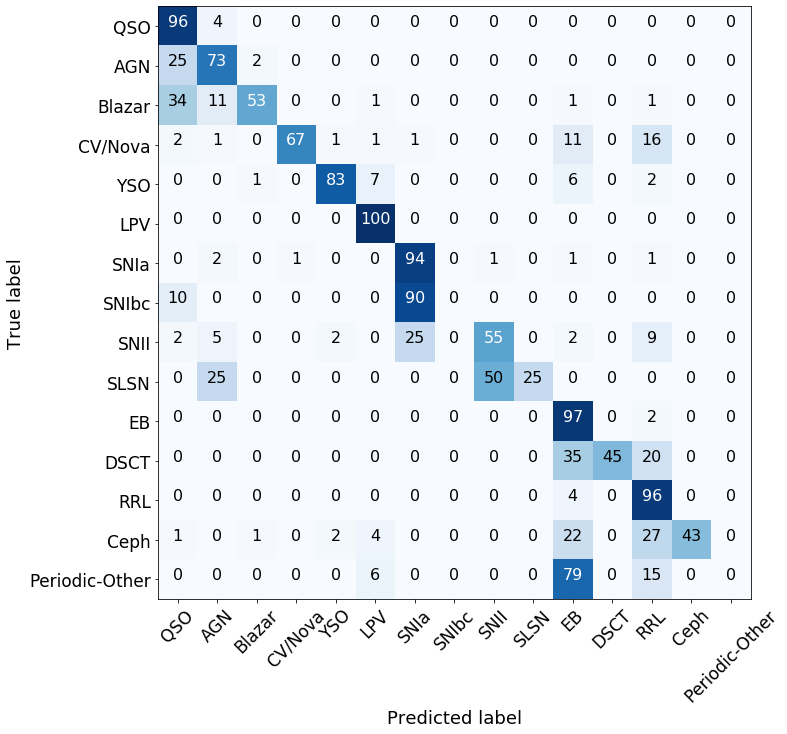

In [11]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(le.inverse_transform(y_test_original), le.inverse_transform(pred), labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,'../../paper_late_classifier/paper_plots/conf_matrix_XGBoost.pdf')



In [12]:
# Kaggle score

CLASSES_REDUCED_V2 = le.inverse_transform(np.arange(len(label_order)))

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(y_test_original,pred_proba))

AGN -0.05399798154830932
Blazar -0.14222893714904786
CV/Nova -0.10576749642690023
Ceph -0.22769033114115397
DSCT -0.1864280382792155
EB -0.006003046035766601
LPV -0.0007068298757076264
Periodic-Other -0.47253538767496744
QSO -0.008382857839266459
RRL -0.008197738726933797
SLSN -0.26231247584025064
SNII -0.14172754287719727
SNIa -0.01530420978864034
SNIbc -0.39291232426961265
YSO -0.03721799453099569
2.0614131920039664


  ## Classifying unlabeled data

In [13]:
#loading the data

print(rm_nd_cols)


mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

    
df_feat_ul_out = df_feat_ul.copy()

df_feat_ul.head()

['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'aps_non_zero_1', 'aps_non_zero_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2']


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaxg,0.200738,0.215184,1.0,1.000000,1.0,1.0,0.452381,0.450000,0.0,0.0,...,0.380952,0.350000,0.739524,0.894375,-0.056,1.655,3.797847,2.142847,4.394539,2.739539
ZTF17aaaadvq,-999.000000,0.316305,-999.0,1.000000,-999.0,1.0,-999.000000,0.055556,-999.0,0.0,...,-999.000000,0.944444,0.690000,0.982625,0.046,1.619,4.563254,2.944254,-999.000000,-999.000000
ZTF17aaaadyl,-999.000000,0.326172,-999.0,1.000000,-999.0,1.0,-999.000000,0.151515,-999.0,0.0,...,-999.000000,0.848485,0.690000,0.988732,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000
ZTF17aaaafce,0.207151,0.198148,1.0,0.999998,1.0,1.0,0.513514,0.428571,0.0,0.0,...,0.243243,0.571429,0.696667,0.993333,-0.029,1.705,3.663143,1.958143,4.416657,2.711657
ZTF17aaaajfv,0.656590,0.488236,1.0,1.000000,1.0,1.0,0.634615,0.508621,0.0,0.0,...,0.442308,0.362069,0.768333,0.985083,-0.351,2.636,4.331154,1.695154,5.044343,2.408343


In [14]:
#predicting classes of unlabeled data

test_Y = le.inverse_transform(clf.predict(df_feat_ul.values))
test_Y_proba = clf.predict_proba(df_feat_ul.values)

In [15]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)

df_out['predicted_class'] = test_Y
df_out['predicted_class_proba'] = test_Y_proba
test_data_withclass = df_out

'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''

(690527, 136)


ValueError: Wrong number of items passed 15, placement implies 1

In [ ]:
test_data_withclass.shape
#class_final_name_ul = le_original.inverse_transform(class_final_name_ul)

In [ ]:
letter_counts = Counter(test_Y_proba)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')


In [ ]:

fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

In [ ]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

In [ ]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['QSO','AGN','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   print(cl,len(df_test[feature_x][df_test['predicted_class']==cl].values))
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

In [ ]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO','AGN','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')